(svgp)=

# SVGP Regression

In [1]:
import sys

sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm.notebook import tqdm

import jaxgp as jgp
from jaxgp.datasets import CustomDataset, NumpyLoader
from jaxgp.types import Dataset

np.random.seed(42)


/Users/lichengk/.miniforge3/envs/py39_forge/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
input_dim = 1
output_dim = 1
num_data = 1000
num_test = 1000
num_inducing = 50
batch_size = 60


def func(X):
    return np.sin(2 * X) + 0.3 * X + np.random.normal(0, 0.1, X.shape)


X = np.random.uniform(-3.0, 3.0, (num_data, input_dim))
Y = func(X)

key = jax.random.PRNGKey(10)

Xtest = jnp.sort(
    jax.random.uniform(key, shape=(num_test, input_dim), minval=-5, maxval=5),
    0,
)


In [3]:
kernel = jgp.kernels.RBF()
gprior = jgp.GPrior(kernel=kernel)
likelihood = jgp.likelihoods.Gaussian()
inducing_points = (
    jax.random.uniform(key=key, shape=(num_inducing, input_dim))
    * (X.max() - X.min())
    + X.min()
)
model = jgp.SVGP(gprior, likelihood, inducing_points, output_dim)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(num_data=num_data, sign=-1.0)

training_data = CustomDataset(X, Y)
train_dataloader = NumpyLoader(
    training_data, batch_size=batch_size, shuffle=True
)


In [4]:
@jax.jit
@jax.value_and_grad
def loss(raw_params, batch):
    return neg_elbo(raw_params, batch)


opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(raw_params)

num_epochs = 400
loss_history = []
for epoch in tqdm(range(num_epochs)):
    for batch in train_dataloader:
        data = Dataset(X=batch[0], Y=batch[1])
        loss_val, grads = loss(raw_params, data)
        updates, opt_state = opt.update(grads, opt_state)
        raw_params = optax.apply_updates(raw_params, updates)
    loss_history.append(loss_val.item())


  0%|          | 0/400 [00:00<?, ?it/s]

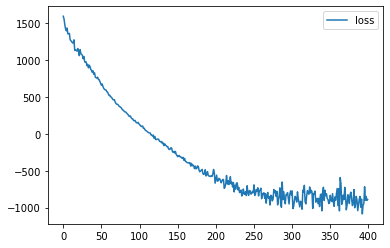

In [5]:
plt.figure()
plt.plot(loss_history, label="loss")
plt.legend()
plt.show()


In [6]:
def plot_model(params):
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2, alpha=0.5)
    plt.plot(
        params["inducing_points"],
        jnp.zeros([num_inducing, input_dim]),
        "|",
        color="tab:red",
        mew=2,
        alpha=0.5,
    )
    mean, var = model.predict_y(params, Xtest)
    plt.plot(Xtest, mean, "tab:orange", lw=2)
    plt.fill_between(
        Xtest[:, 0],
        mean[:, 0] - 1.96 * jnp.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * jnp.sqrt(var[:, 0]),
        color="tab:blue",
        alpha=0.5,
    )
    plt.xlabel("x")
    plt.xlabel("y")
    plt.show()


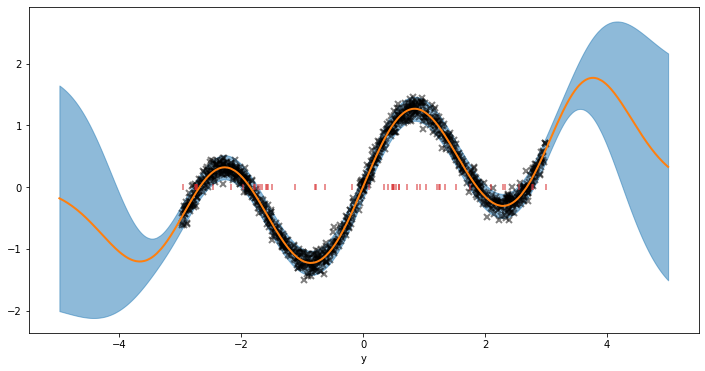

In [7]:
params = constrain_trans(raw_params)
plot_model(params)
